<a href="https://colab.research.google.com/github/ikonushok/My_studying_Data-Science-and-Neyro-Nets-on-Python/blob/master/%D0%94%D0%97_12_Light_%D0%A1%D0%B5%D0%B3%D0%BC%D0%B5%D0%BD%D1%82%D0%B0%D1%86%D0%B8%D1%8F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*Теоретический материал:* https://youtu.be/E8RsblFqFZs?t=284

## Подключение бибилиотек

*Разбор данного раздела:* https://youtu.be/E8RsblFqFZs?t=698

In [13]:
from tensorflow.keras.models import Model # Импортируем модели keras: Model
from tensorflow.keras.layers import Input, Conv2DTranspose, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization # Импортируем стандартные слои keras
from tensorflow.keras import backend as K # Импортируем модуль backend keras'а
from tensorflow.keras.optimizers import Adam, Nadam, Adamax # Импортируем оптимизатор Adam
from tensorflow.keras import utils # Импортируем модуль utils библиотеки tensorflow.keras для получения OHE-представления
from google.colab import files # Импортируем Модуль files для работы с файлами
import matplotlib.pyplot as plt # Импортируем модуль pyplot библиотеки matplotlib для построения графиков
from tensorflow.keras.preprocessing import image # Импортируем модуль image для работы с изображениями
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from IPython.display import clear_output
import numpy as np # Импортируем библиотеку numpy
from sklearn.model_selection import train_test_split
import time, random, os

from PIL import Image # импортируем модель Image для работы с изображениями

In [14]:
from google.colab import drive # Подключаем гугл-диск
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
# Глобальные параметры
img_width = 176 # Ширина уменьшенной картинки 
img_height = 240 # Высота уменьшенной картинки 
num_classes = 7 # Задаем количество классов на изображении
directory = '/content/drive/My Drive/Занятие_12_Сегментация/Сегментация/' # Указываем путь к обучающей выборке с оригинальными изображения
train_directory = 'Тренировочная_стройка' # Название папки с файлами обучающей выборки
val_directory = 'Проверочная_стройка' # Название папки с файлами проверочной выборки

## Загрузка картинок

*Разбор данного раздела:* https://youtu.be/E8RsblFqFZs?t=752


In [16]:
os.chdir('/content/drive/My Drive/Занятие_12_Сегментация/data_стройка')
xTrain, yTrain = np.load('xTrain.npy'), np.load('yTrain.npy')
xVal, yVal= np.load('xVal.npy'), np.load('yVal.npy')
print('xTrain\t', xTrain.shape, '\nyTrain\t', yTrain.shape,
      '\nxVal\t', xVal.shape, '\nyVal\t', yVal.shape)

xTrain	 (900, 176, 240, 3) 
yTrain	 (900, 176, 240, 7) 
xVal	 (50, 176, 240, 3) 
yVal	 (50, 176, 240, 7)


## Функции визуализации и ошибок

*Разбор данного раздела:* https://youtu.be/E8RsblFqFZs?t=2056

In [17]:
# Функция визуализации сегментированных изображений
def processImage(model, count = 1, n_classes = 6):
  indexes = np.random.randint(0, len(xVal), count) # Получаем count случайных индексов
  fig, axs = plt.subplots(3, count, figsize=(16, 6)) #Создаем полотно из n графиков
  for i,idx in enumerate(indexes): # Проходим по всем сгенерированным индексам
    predict = np.array(model.predict(xVal[idx].reshape(1, img_width, img_height, 3))) # Предиктим картику
    pr = predict[0] # Берем нулевой элемент из перидкта
    pr1 = [] # Пустой лист под сегментированную картинку из predicta
    pr2 = [] # Пустой лист под сегменитрованную картинку из yVal
    pr = pr.reshape(-1, n_classes) # Решейпим предикт
    yr = yVal[idx].reshape(-1, n_classes) # Решейпим yVal
    for k in range(len(pr)): # Проходим по всем уровням (количесвто классов)
      pr1.append(index2color(pr[k])) # Переводим индекс в писксель
      pr2.append(index2color(yr[k])) # Переводим индекс в писксель
    pr1 = np.array(pr1) # Преобразуем в numpy
    pr1 = pr1.reshape(img_width, img_height,3) # Решейпим к размеру изображения
    pr2 = np.array(pr2) # Преобразуем в numpy
    pr2 = pr2.reshape(img_width, img_height,3) # Решейпим к размеру изображения
    img = Image.fromarray(pr1.astype('uint8')) # Получаем картику из предикта
    axs[0,i].imshow(img.convert('RGBA')) # Отображаем на графике в первой линии
    axs[1,i].imshow(Image.fromarray(pr2.astype('uint8'))) # Отображаем на графике во второй линии сегментированное изображение из yVal
    axs[2,i].imshow(Image.fromarray(xVal[idx].astype('uint8'))) # Отображаем на графике в третьей линии оригинальное изображение        
  plt.show()  

In [18]:
'''
  Собственная функция метрики, обрабатывающая пересечение двух областей
'''
def dice_coef(y_true, y_pred):
    return (2. * K.sum(y_true * y_pred) + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.) # Возвращаем площадь пересечения деленную на площадь объединения двух областей

In [19]:
# Функция преобразования индекса в цвет пикселя
def index2color(index2):
  index = np.argmax(index2) # Получаем индекс максимального элемента
  color=[]
  if   index == 0: color = [100, 100, 100]  # пол
  elif index == 1: color = [0, 0, 100]  # потолок
  elif index == 2: color = [0, 100, 0]  # стена
  elif index == 3: color = [100, 0, 0]  # проем, дверь, окно
  elif index == 4: color = [0, 100, 100]  # колонна, лестница, внешний мир, перила, батарея, инвентарь, источники света, провода, балка
  elif index == 5: color = [100, 0, 100]  # люди
  elif index == 6: color = [0, 0, 0]  # остальное
  return color # Возвращаем цвет пикслея

# Упрощённая U-net

*Разбор данного раздела:* https://youtu.be/E8RsblFqFZs?t=3391

### Создание сети и обучение

In [9]:
'''
  Функция создания сети
    Входные параметры:
    - num_classes - количество классов
    - input_shape - размерность карты сегментации
'''
def simpleUnet(num_classes = 6, input_shape= (352, 480, 3)):
    img_input = Input(input_shape)                                         # Создаем входной слой с размерностью input_shape

    # Block 1
    x = Conv2D(32, (3, 3), padding='same', name='block1_conv1')(img_input) # Добавляем Conv2D-слой с 32-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(32, (3, 3), padding='same', name='block1_conv2')(x)         # Добавляем Conv2D-слой с 32-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    block_1_out = Activation('relu')(x)                                    # Добавляем слой Activation и запоминаем в переменной block_1_out

    x = MaxPooling2D()(block_1_out)                                        # Добавляем слой MaxPooling2D

    # Block 2
    x = Conv2D(64, (3, 3), padding='same', name='block2_conv1')(x)         # Добавляем Conv2D-слой с 64-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(64, (3, 3), padding='same', name='block2_conv2')(x)         # Добавляем Conv2D-слой с 64-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    block_2_out = Activation('relu')(x)                                    # Добавляем слой Activation и запоминаем в переменной block_2_out

    x = MaxPooling2D()(block_2_out)                                        # Добавляем слой MaxPooling2D
    
    # UP 1
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x)     # Добавляем Conv2DTranspose-слой с 64-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(64, (3, 3), padding='same')(x)                              # Добавляем Conv2D-слой с 64-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(64, (3, 3), padding='same')(x)                              # Добавляем Conv2D-слой с 64-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    # UP 2
    x = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(x)     # Добавляем Conv2DTranspose-слой с 32-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(32, (3, 3), padding='same')(x)                              # Добавляем Conv2D-слой с 32-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(32, (3, 3), padding='same')(x)                              # Добавляем Conv2D-слой с 32-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(num_classes,(3,3), activation='softmax', padding='same')(x) # Добавляем Conv2D-Слой с softmax-активацией на num_classes-нейронов

    model = Model(img_input, x)                                            # Создаем модель с входом 'img_input' и выходом 'x'

    # Компилируем модель
    model.compile(optimizer=Adam(lr=1e-3),
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])
    
    return model                                                           # Возвращаем модель

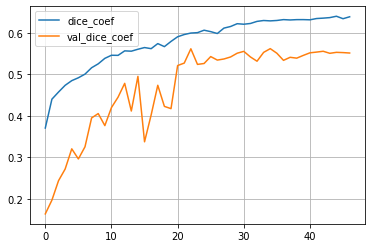

In [ ]:
modelS = simpleUnet(num_classes, (img_width, img_height, 3))

#Коллбэки
early_stopping = EarlyStopping(monitor = 'val_dice_coef', patience = 12, verbose = 0, restore_best_weights = True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_dice_coef', factor=0.5, patience=5, min_lr=1e-06, verbose = 1, mode='max')
Checkpoint = ModelCheckpoint('modelS.h5', monitor='val_dice_coef', verbose=1, save_best_only=True, save_weights_only=True, mode='max')

# Обучаем модель simpleUnet
history = modelS.fit(xTrain, yTrain, validation_data = (xVal, yVal),
                     epochs=100, batch_size=32, verbose=0,
                     callbacks = [early_stopping, reduce_lr, Checkpoint]) # Обучаем модель на выборке по трем классам

#Выводим график точности распознавания на обучающей и проверочной выборках
clear_output()
plt.plot(history.history['dice_coef'], label='dice_coef')
plt.plot(history.history['val_dice_coef'], label='val_dice_coef')
plt.legend()
plt.grid()
plt.show()

### Распознавание

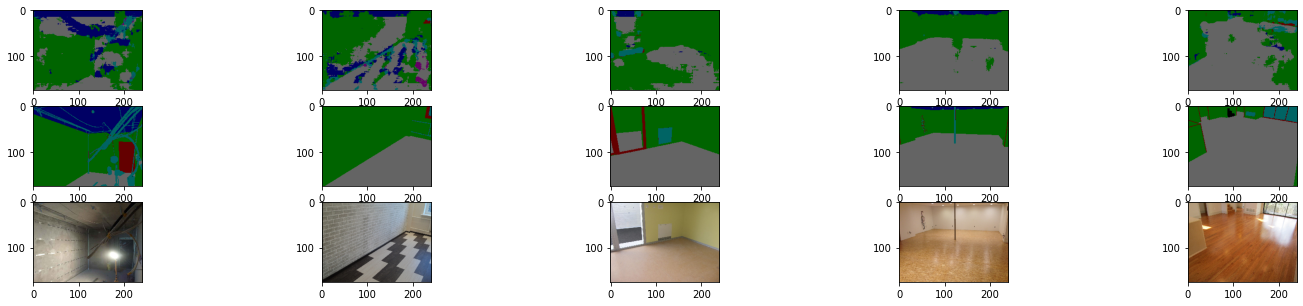

In [ ]:
modelS = simpleUnet(num_classes, (img_width, img_height, 3))    
modelS.load_weights('/content/drive/My Drive/Занятие_12_Сегментация/data_стройка/modelS.h5')
processImage(modelS, 5, num_classes)

# Расширенная U-net


### Создание и обучение сети

In [8]:
'''
  Функция создания сети
    Входные параметры:
    - num_classes - количество классов
    - input_shape - размерность карты сегментации
'''
def unetWithMask(num_classes, input_shape= (352, 480, 3)):
    img_input = Input(input_shape)                                      # Создаем входной слой с размерностью input_shape

    # Block 1
    x = Conv2D(64, (3, 3), padding='same', name='block1_conv1')(img_input) # Добавляем Conv2D-слой с 64-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    x = Conv2D(64, (3, 3), padding='same', name='block1_conv2')(x)      # Добавляем Conv2D-слой с 64-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    block_1_out = Activation('relu')(x)                                 # Добавляем слой Activation и запоминаем в переменной block_1_out
    
    block_1_out_mask = Conv2D(64, (1, 1), padding='same')(block_1_out)  # Добавляем Conv2D-маску к текущему слою и запоминаем в переменную block_1_out_mask

    x = MaxPooling2D()(block_1_out) # Добавляем слой MaxPooling2D

    # Block 2
    x = Conv2D(128, (3, 3), padding='same', name='block2_conv1')(x)     # Добавляем Conv2D-слой с 128-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x) # Добавляем слой Activation

    x = Conv2D(128, (3, 3), padding='same', name='block2_conv2')(x)     # Добавляем Conv2D-слой с 128-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    block_2_out = Activation('relu')(x)                                 # Добавляем слой Activation и запоминаем в переменной block_2_out

    block_2_out_mask = Conv2D(128, (1, 1), padding='same')(block_2_out) # Добавляем Conv2D-маску к текущему слою и запоминаем в переменную block_2_out_mask
    
    x = MaxPooling2D()(block_2_out)                                     # Добавляем слой MaxPooling2D

    # Block 3
    x = Conv2D(256, (3, 3), padding='same', name='block3_conv1')(x)     # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv2')(x)     # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv3')(x)     # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    block_3_out = Activation('relu')(x)                                 # Добавляем слой Activation и запоминаем в переменной block_3_out

    block_3_out_mask = Conv2D(256, (1, 1), padding='same')(block_3_out) # Добавляем Conv2D-маску к текущему слою и запоминаем в переменную block_3_out_mask
        
    x = MaxPooling2D()(block_3_out)                                     # Добавляем слой MaxPooling2D

     # Block 4
    x = Conv2D(512, (3, 3), padding='same', name='block4_conv1')(x)     # Добавляем Conv2D-слой с 512-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv2')(x)     # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv3')(x)     # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    block_4_out = Activation('relu')(x)                                 # Добавляем слой Activation и запоминаем в переменной block_4_out

    block_4_out_mask = Conv2D(512, (1, 1), padding='same')(block_4_out) # Добавляем Conv2D-маску к текущему слою и запоминаем в переменную block_4_out_mask
            
    x = MaxPooling2D()(block_4_out)                                     # Добавляем слой MaxPooling2D

    # Block 5
    x = Conv2D(512, (3, 3), padding='same', name='block5_conv1')(x)     # Добавляем Conv2D-слой с 512-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    x = Conv2D(512, (3, 3), padding='same', name='block5_conv2')(x)     # Добавляем Conv2D-слой с 512-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    x = Conv2D(512, (3, 3), padding='same', name='block5_conv3')(x)     # Добавляем Conv2D-слой с 512-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation
    
    for_pretrained_weight = MaxPooling2D()(x)                           # Добавляем слой MaxPooling2D
 
    # UP 1
    x = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(x) # Добавляем слой Conv2DTranspose с 512 нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    x = concatenate([x, block_4_out, block_4_out_mask])                 # Объединем текущий слой со слоем block_4_out и слоем-маской block_4_out_mask
    x = Conv2D(512, (3, 3), padding='same')(x)                          # Добавляем слой Conv2D с 512 нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    x = Conv2D(512, (3, 3), padding='same')(x)                          # Добавляем слой Conv2D с 512 нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    # UP 2
    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x) # Добавляем слой Conv2DTranspose с 256 нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    x = concatenate([x, block_3_out, block_3_out_mask])                 # Объединем текущий слой со слоем block_3_out и слоем-маской block_3_out_mask
    x = Conv2D(256, (3, 3), padding='same')(x)                          # Добавляем слой Conv2D с 256 нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    x = Conv2D(256, (3, 3), padding='same')(x)                          # Добавляем слой Conv2D с 256 нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    # UP 3
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x) # Добавляем слой Conv2DTranspose с 128 нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    x = concatenate([x, block_2_out, block_2_out_mask])                 # Объединем текущий слой со слоем block_2_out и слоем-маской block_2_out_mask
    x = Conv2D(128, (3, 3), padding='same')(x)                          # Добавляем слой Conv2D с 128 нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    x = Conv2D(128, (3, 3), padding='same')(x)                          # Добавляем слой Conv2D с 128 нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    # UP 4
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x) # Добавляем слой Conv2DTranspose с 64 нейронами
    x = BatchNormalization()(x)                                        # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                          # Добавляем слой Activation

    x = concatenate([x, block_1_out, block_1_out_mask])                # Объединем текущий слой со слоем block_1_out и слоем-маской block_1_out_mask
    x = Conv2D(64, (3, 3), padding='same')(x)                          # Добавляем слой Conv2D с 128 нейронами
    x = BatchNormalization()(x)                                        # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                          # Добавляем слой Activation

    x = Conv2D(64, (3, 3), padding='same')(x)                          # Добавляем слой Conv2D с 128 нейронами
    x = BatchNormalization()(x)                                        # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                          # Добавляем слой Activation

    x = Conv2D(num_classes, (3, 3), activation='softmax', padding='same')(x) # Добавляем Conv2D-Слой с softmax-активацией на num_classes-нейронов

    model = Model(img_input, x)                                        # Создаем модель с входом 'img_input' и выходом 'x'

    # Компилируем модель 
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=[dice_coef])
    
    return model                                                       # Возвращаем сформированную модель

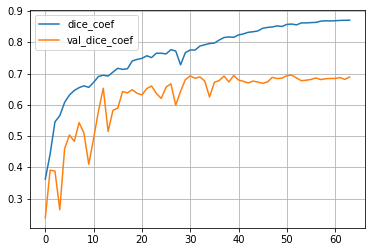

In [ ]:
modelM3 = unetWithMask(num_classes, (img_width, img_height, 3))

#Коллбэки
early_stopping = EarlyStopping(monitor = 'val_dice_coef', patience = 12, verbose = 0, restore_best_weights = True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_dice_coef', factor=0.5, patience=5, min_lr=1e-06, verbose = 1, mode='max')
Checkpoint = ModelCheckpoint('modelM3.h5', monitor='val_dice_coef', verbose=1, save_best_only=True, save_weights_only=True, mode='max')

# Обучаем модель simpleUnet
history = modelM3.fit(xTrain, yTrain, validation_data = (xVal, yVal),
                     epochs=100, batch_size=16, verbose=0,
                     callbacks = [early_stopping, reduce_lr, Checkpoint]) # Обучаем модель на выборке по 7 классам

#Выводим график точности распознавания на обучающей и проверочной выборках
clear_output()
plt.plot(history.history['dice_coef'], label='dice_coef')
plt.plot(history.history['val_dice_coef'], label='val_dice_coef')
plt.legend()
plt.grid()
plt.show()

### Распознавание сразу всех обьектов

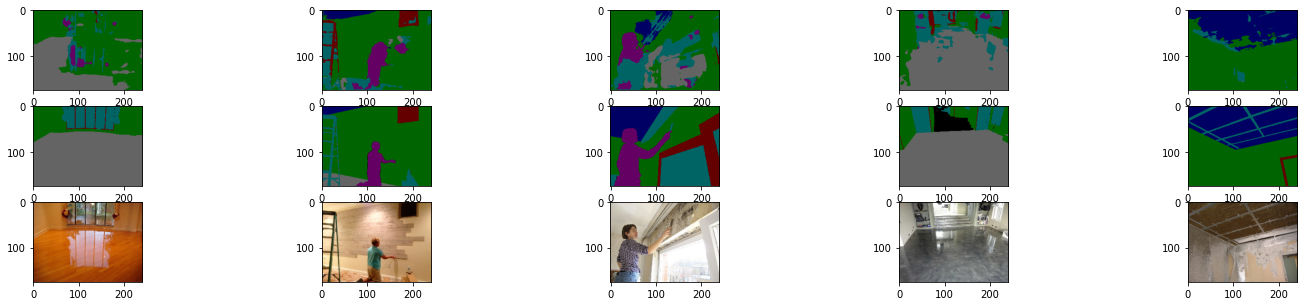

In [ ]:
modelM3 = unetWithMask(num_classes, (img_width, img_height, 3))
modelM3.load_weights('/content/drive/My Drive/Занятие_12_Сегментация/data_стройка/modelM3.h5')
processImage(modelM3, 5, num_classes)

# Обучение по отдельным классам

In [58]:
os.chdir('/content/drive/My Drive/Занятие_12_Сегментация/data_стройка')

### Фунции НС и подготовки выборки

In [11]:
num_classes = 2

In [12]:
# Функция перевода индекса пикслея в to_categorical
def rgbToohe(y, num_classes): 
  y2 = y.copy() # Создаем копию входного массива
  y = y.reshape(y.shape[0] * y.shape[1], 3) # Решейпим в двумерный массив
  yt = [] # Создаем пустой лист
  for i in range(len(y)): # Проходим по всем трем канала изображения
    yt.append(utils.to_categorical(color2index(y[i]), num_classes=num_classes)) # Переводим пиксели в индексы и преобразуем в OHE
  yt = np.array(yt) # Преобразуем в numpy
  yt = yt.reshape(y2.shape[0], y2.shape[1], num_classes) # Решейпим к исходныму размеру
  return yt # Возвращаем сформированный массив

In [13]:
# Функция формирования yTrain
def yt_prep(data, num_classes):
  yTrain = [] # Создаем пустой список под карты сегметации
  for seg in data: # Пробегаем по всем файлам набора с сегминтированными изображениями
    y = image.img_to_array(seg) # Переводим изображение в numpy-массив размерностью: высота - ширина - количество каналов
    y = rgbToohe(y, num_classes) # Получаем OHE-представление сформированного массива
    yTrain.append(y) # Добавляем очередной элемент в yTrain
    if len(yTrain) % 100 == 0: # Каждые 100 шагов
      print(len(yTrain)) # Выводим количество обработанных изображений
  return np.array(yTrain) # Возвращаем сформированный yTrain

In [14]:
'''
  Функция создания сети
    Входные параметры:
    - num_classes - количество классов
    - input_shape - размерность карты сегментации
'''
def unetWithMask(num_classes, input_shape= (352, 480, 3)):
    img_input = Input(input_shape)                                      # Создаем входной слой с размерностью input_shape

    # Block 1
    x = Conv2D(64, (3, 3), padding='same', name='block1_conv1')(img_input) # Добавляем Conv2D-слой с 64-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    x = Conv2D(64, (3, 3), padding='same', name='block1_conv2')(x)      # Добавляем Conv2D-слой с 64-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    block_1_out = Activation('relu')(x)                                 # Добавляем слой Activation и запоминаем в переменной block_1_out
    
    block_1_out_mask = Conv2D(64, (1, 1), padding='same')(block_1_out)  # Добавляем Conv2D-маску к текущему слою и запоминаем в переменную block_1_out_mask

    x = MaxPooling2D()(block_1_out) # Добавляем слой MaxPooling2D

    # Block 2
    x = Conv2D(128, (3, 3), padding='same', name='block2_conv1')(x)     # Добавляем Conv2D-слой с 128-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x) # Добавляем слой Activation

    x = Conv2D(128, (3, 3), padding='same', name='block2_conv2')(x)     # Добавляем Conv2D-слой с 128-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    block_2_out = Activation('relu')(x)                                 # Добавляем слой Activation и запоминаем в переменной block_2_out

    block_2_out_mask = Conv2D(128, (1, 1), padding='same')(block_2_out) # Добавляем Conv2D-маску к текущему слою и запоминаем в переменную block_2_out_mask
    
    x = MaxPooling2D()(block_2_out)                                     # Добавляем слой MaxPooling2D

    # Block 3
    x = Conv2D(256, (3, 3), padding='same', name='block3_conv1')(x)     # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv2')(x)     # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv3')(x)     # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    block_3_out = Activation('relu')(x)                                 # Добавляем слой Activation и запоминаем в переменной block_3_out

    block_3_out_mask = Conv2D(256, (1, 1), padding='same')(block_3_out) # Добавляем Conv2D-маску к текущему слою и запоминаем в переменную block_3_out_mask
        
    x = MaxPooling2D()(block_3_out)                                     # Добавляем слой MaxPooling2D

     # Block 4
    x = Conv2D(512, (3, 3), padding='same', name='block4_conv1')(x)     # Добавляем Conv2D-слой с 512-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv2')(x)     # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv3')(x)     # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    block_4_out = Activation('relu')(x)                                 # Добавляем слой Activation и запоминаем в переменной block_4_out

    block_4_out_mask = Conv2D(512, (1, 1), padding='same')(block_4_out) # Добавляем Conv2D-маску к текущему слою и запоминаем в переменную block_4_out_mask
            
    x = MaxPooling2D()(block_4_out)                                     # Добавляем слой MaxPooling2D

    # Block 5
    x = Conv2D(512, (3, 3), padding='same', name='block5_conv1')(x)     # Добавляем Conv2D-слой с 512-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    x = Conv2D(512, (3, 3), padding='same', name='block5_conv2')(x)     # Добавляем Conv2D-слой с 512-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    x = Conv2D(512, (3, 3), padding='same', name='block5_conv3')(x)     # Добавляем Conv2D-слой с 512-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation
    
    for_pretrained_weight = MaxPooling2D()(x)                           # Добавляем слой MaxPooling2D
 
    # UP 1
    x = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(x) # Добавляем слой Conv2DTranspose с 512 нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    x = concatenate([x, block_4_out, block_4_out_mask])                 # Объединем текущий слой со слоем block_4_out и слоем-маской block_4_out_mask
    x = Conv2D(512, (3, 3), padding='same')(x)                          # Добавляем слой Conv2D с 512 нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    x = Conv2D(512, (3, 3), padding='same')(x)                          # Добавляем слой Conv2D с 512 нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    # UP 2
    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x) # Добавляем слой Conv2DTranspose с 256 нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    x = concatenate([x, block_3_out, block_3_out_mask])                 # Объединем текущий слой со слоем block_3_out и слоем-маской block_3_out_mask
    x = Conv2D(256, (3, 3), padding='same')(x)                          # Добавляем слой Conv2D с 256 нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    x = Conv2D(256, (3, 3), padding='same')(x)                          # Добавляем слой Conv2D с 256 нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    # UP 3
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x) # Добавляем слой Conv2DTranspose с 128 нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    x = concatenate([x, block_2_out, block_2_out_mask])                 # Объединем текущий слой со слоем block_2_out и слоем-маской block_2_out_mask
    x = Conv2D(128, (3, 3), padding='same')(x)                          # Добавляем слой Conv2D с 128 нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    x = Conv2D(128, (3, 3), padding='same')(x)                          # Добавляем слой Conv2D с 128 нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    # UP 4
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x) # Добавляем слой Conv2DTranspose с 64 нейронами
    x = BatchNormalization()(x)                                        # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                          # Добавляем слой Activation

    x = concatenate([x, block_1_out, block_1_out_mask])                # Объединем текущий слой со слоем block_1_out и слоем-маской block_1_out_mask
    x = Conv2D(64, (3, 3), padding='same')(x)                          # Добавляем слой Conv2D с 128 нейронами
    x = BatchNormalization()(x)                                        # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                          # Добавляем слой Activation

    x = Conv2D(64, (3, 3), padding='same')(x)                          # Добавляем слой Conv2D с 128 нейронами
    x = BatchNormalization()(x)                                        # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                          # Добавляем слой Activation

    x = Conv2D(num_classes, (3, 3), activation='softmax', padding='same')(x) # Добавляем Conv2D-Слой с softmax-активацией на num_classes-нейронов

    model = Model(img_input, x)                                        # Создаем модель с входом 'img_input' и выходом 'x'

    # Компилируем модель 
    model.compile(optimizer=Adam(0.0002, 0.5),
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])
    
    return model          

### Человек

In [ ]:
yTrain = np.load('yTrain_man.npy')
yVal = np.load('yVal_man.npy')
yTrain.shape, yVal.shape

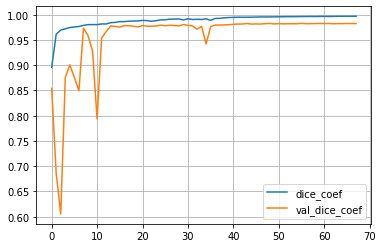

In [65]:
modelM3 = unetWithMask(num_classes, (img_width, img_height, 3))

#Коллбэки
early_stopping = EarlyStopping(monitor = 'val_dice_coef', patience = 12, verbose = 0, restore_best_weights = True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_dice_coef', factor=0.5, patience=5, min_lr=1e-06, verbose = 1, mode='max')
Checkpoint = ModelCheckpoint('modelM3_man.h5', monitor='val_dice_coef', verbose=1, save_best_only=True, save_weights_only=True, mode='max')

# Обучаем модель simpleUnet
history = modelM3.fit(xTrain, yTrain, validation_data = (xVal, yVal),
                      epochs=100, batch_size=16, verbose=0,
                      callbacks = [early_stopping, reduce_lr, Checkpoint]) # Обучаем модель на выборке по 2м классам

#Выводим график точности распознавания на обучающей и проверочной выборках
clear_output()
plt.plot(history.history['dice_coef'], label='dice_coef')
plt.plot(history.history['val_dice_coef'], label='val_dice_coef')
plt.legend()
plt.grid()
plt.show()

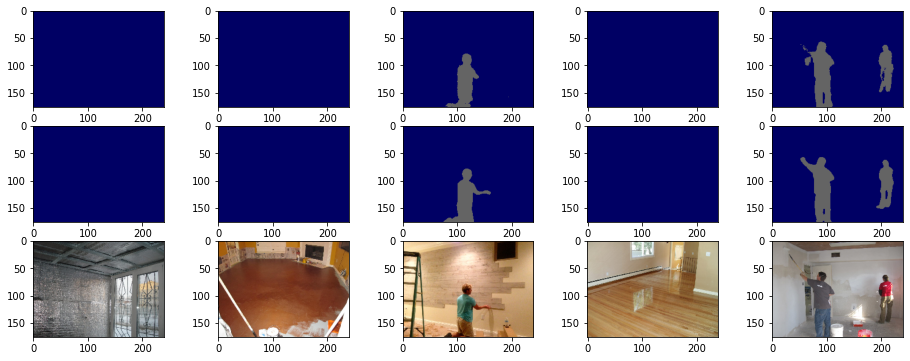

In [69]:
processImage(modelM3, 5, num_classes)

#### больше не запускать

In [16]:
# Функция преобразования пикселя сегментированного изображения в индекс (2 класса)
def color2index(color):
  index=-1
  if (49>=color[0]>=0) and(249>=color[1]>=151) and(249>=color[2]>=151) : index=0 # люди
  else: index = 1
  return index  

In [43]:
train_segments = [] # Создаем пустой список для хранений оригинльных изображений обучающей выборки
val_segments = [] # Создаем пустой список для хранений оригинльных изображений проверочной выборки

cur_time = time.time() # Засекаем текущее время
for filename in sorted(os.listdir(directory + train_directory+'/Размеченные')): # Проходим по всем файлам в каталоге по указанному пути     
    train_segments.append(image.load_img(os.path.join(directory + train_directory+'/Размеченные',filename),
                                       target_size=(img_width, img_height))) # Читаем очередную картинку и добавляем ее в список изображения с указанным target_size                                                      
print ('Обучающая выборка загружена. Время загрузки: ', round(time.time() - cur_time, 2), 'c', sep='') # Отображаем время загрузки картинок обучающей выборки
print ('Количество изображений: ', len(train_segments)) # Отображаем количество элементов в обучающем наборе сегментированных изображений

cur_time = time.time() # Засекаем текущее время
# Проходим по всем файлам в каталоге по указанному пути 
for filename in sorted(os.listdir(directory + val_directory+'/Размеченные')):
    # Читаем очередную картинку и добавляем ее в список изображения с указанным target_size                                                      
    val_segments.append(image.load_img(os.path.join(directory + val_directory+'/Размеченные',filename), 
                                     target_size=(img_width, img_height)))  # Читаем очередную картинку и добавляем ее в список изображения с указанным target_size   
print ('Проверочная выборка загружена. Время загрузки: ', round(time.time() - cur_time, 2), 'c', sep='') # Отображаем время загрузки картинок проверочной выборки
print ('Количество изображений: ', len(val_segments)) # Отображаем количество элементов в проверочном наборе сегментированных изображений

Обучающая выборка загружена. Время загрузки: 4.77c
Количество изображений:  900
Проверочная выборка загружена. Время загрузки: 0.24c
Количество изображений:  50


In [40]:
#os.chdir('/content/drive/My Drive/Занятие_12_Сегментация/data_стройка')
#with open("train_segments_man.txt", "w") as file: print(train_segments, sep="\n", file=file)
#with open("val_segments_man.txt", "w") as file: print(val_segments, sep="\n", file=file)

In [48]:
cur_time = time.time() # Засекаем текущее время
yTrain = yt_prep(train_segments, num_classes)  # Создаем yTrain
print('Время обработки: ', round(time.time() - cur_time, 2),'c') # Выводим время работы
np.save('yTrain_man', yTrain)

100
200
300
400
500
600
700
800
900
Время обработки:  584.06 c


In [49]:
cur_time = time.time() # Засекаем текущее время
yVal = yt_prep(val_segments, num_classes) # Создаем yVal
print('Время обработки: ', round(time.time() - cur_time, 2),'c') # Выводим время работы
np.save('yVal_man', yVal)

Время обработки:  30.4 c


### Пол

In [83]:
yTrain = np.load('yTrain_floor.npy')
yVal = np.load('yVal_floor.npy')
yTrain.shape, yVal.shape

((900, 176, 240, 2), (50, 176, 240, 2))

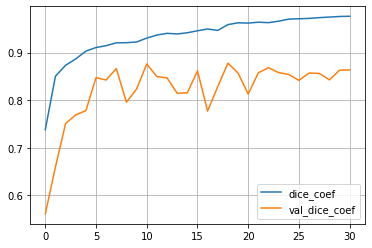

In [84]:
modelM3 = unetWithMask(num_classes, (img_width, img_height, 3))

#Коллбэки
early_stopping = EarlyStopping(monitor = 'val_dice_coef', patience = 12, verbose = 0, restore_best_weights = True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_dice_coef', factor=0.5, patience=5, min_lr=1e-06, verbose = 1, mode='max')
Checkpoint = ModelCheckpoint('modelM3_floor.h5', monitor='val_dice_coef', verbose=1, save_best_only=True, save_weights_only=True, mode='max')

# Обучаем модель simpleUnet
history = modelM3.fit(xTrain, yTrain, validation_data = (xVal, yVal),
                      epochs=100, batch_size=16, verbose=0,
                      callbacks = [early_stopping, reduce_lr, Checkpoint]) # Обучаем модель на выборке по 2м классам

#Выводим график точности распознавания на обучающей и проверочной выборках
clear_output()
plt.plot(history.history['dice_coef'], label='dice_coef')
plt.plot(history.history['val_dice_coef'], label='val_dice_coef')
plt.legend()
plt.grid()
plt.show()

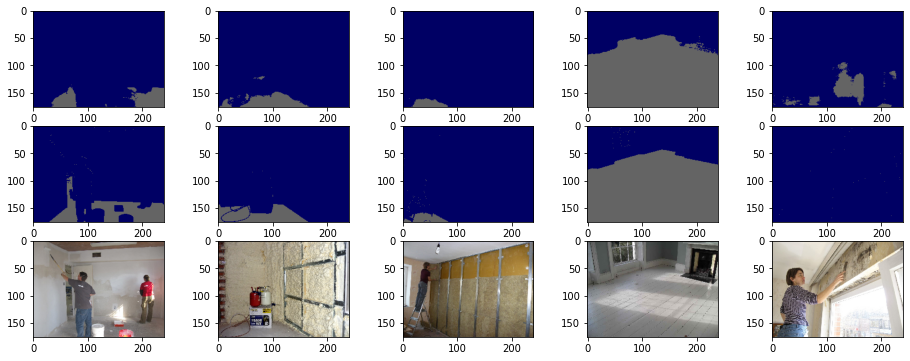

In [86]:
processImage(modelM3, 5, num_classes)

#### больше не запускать

In [101]:
# Функция преобразования пикселя сегментированного изображения в индекс (2 класса)
def color2index(color):
  index=-1
  if   (149>=color[0]>51)   and(149>=color[1]>=51)  and(149>=color[2]>=51) : index=0 # пол
  else: index = 1
  return index  

In [102]:
train_segments = [] # Создаем пустой список для хранений оригинльных изображений обучающей выборки
val_segments = [] # Создаем пустой список для хранений оригинльных изображений проверочной выборки

cur_time = time.time() # Засекаем текущее время
for filename in sorted(os.listdir(directory + train_directory+'/Размеченные')): # Проходим по всем файлам в каталоге по указанному пути     
    train_segments.append(image.load_img(os.path.join(directory + train_directory+'/Размеченные',filename),
                                       target_size=(img_width, img_height))) # Читаем очередную картинку и добавляем ее в список изображения с указанным target_size                                                      
print ('Обучающая выборка загружена. Время загрузки: ', round(time.time() - cur_time, 2), 'c', sep='') # Отображаем время загрузки картинок обучающей выборки
print ('Количество изображений: ', len(train_segments)) # Отображаем количество элементов в обучающем наборе сегментированных изображений

cur_time = time.time() # Засекаем текущее время
# Проходим по всем файлам в каталоге по указанному пути 
for filename in sorted(os.listdir(directory + val_directory+'/Размеченные')):
    # Читаем очередную картинку и добавляем ее в список изображения с указанным target_size                                                      
    val_segments.append(image.load_img(os.path.join(directory + val_directory+'/Размеченные',filename), 
                                     target_size=(img_width, img_height)))  # Читаем очередную картинку и добавляем ее в список изображения с указанным target_size   
print ('Проверочная выборка загружена. Время загрузки: ', round(time.time() - cur_time, 2), 'c', sep='') # Отображаем время загрузки картинок проверочной выборки
print ('Количество изображений: ', len(val_segments)) # Отображаем количество элементов в проверочном наборе сегментированных изображений

Обучающая выборка загружена. Время загрузки: 4.62c
Количество изображений:  900
Проверочная выборка загружена. Время загрузки: 0.24c
Количество изображений:  50


In [ ]:
cur_time = time.time() # Засекаем текущее время
yTrain = yt_prep(train_segments, num_classes)  # Создаем yTrain
print('Время обработки: ', round(time.time() - cur_time, 2),'c') # Выводим время работы
np.save('yTrain_floor', yTrain)
yTrain.shape

In [82]:
cur_time = time.time() # Засекаем текущее время
yVal = yt_prep(val_segments, num_classes) # Создаем yVal
print('Время обработки: ', round(time.time() - cur_time, 2),'c') # Выводим время работы
np.save('yVal_floor', yVal)
yVal.shape

Время обработки:  34.55 c


(50, 176, 240, 2)

In [ ]:
yTrain.shape, yVal.shape
np.save('yTrain_floor', yTrain)
np.save('yVal_floor', yTrain)
yTrain.shape

### Батареи

In [111]:
yTrain = np.load('yTrain_battery.npy')
yVal = np.load('yVal_battery.npy')
yTrain.shape, yVal.shape

((900, 176, 240, 2), (50, 176, 240, 2))

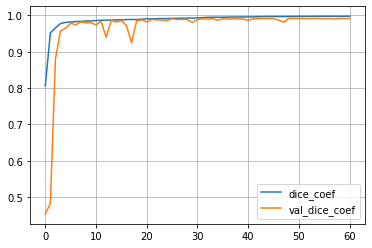

In [112]:
modelM3 = unetWithMask(num_classes, (img_width, img_height, 3))

#Коллбэки
early_stopping = EarlyStopping(monitor = 'val_dice_coef', patience = 12, verbose = 0, restore_best_weights = True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_dice_coef', factor=0.5, patience=5, min_lr=1e-06, verbose = 1, mode='max')
Checkpoint = ModelCheckpoint('modelM3_battery.h5', monitor='val_dice_coef', verbose=1, save_best_only=True, save_weights_only=True, mode='max')

# Обучаем модель simpleUnet
history = modelM3.fit(xTrain, yTrain, validation_data = (xVal, yVal),
                      epochs=100, batch_size=16, verbose=0,
                      callbacks = [early_stopping, reduce_lr, Checkpoint]) # Обучаем модель на выборке по 2м классам

#Выводим график точности распознавания на обучающей и проверочной выборках
clear_output()
plt.plot(history.history['dice_coef'], label='dice_coef')
plt.plot(history.history['val_dice_coef'], label='val_dice_coef')
plt.legend()
plt.grid()
plt.show()

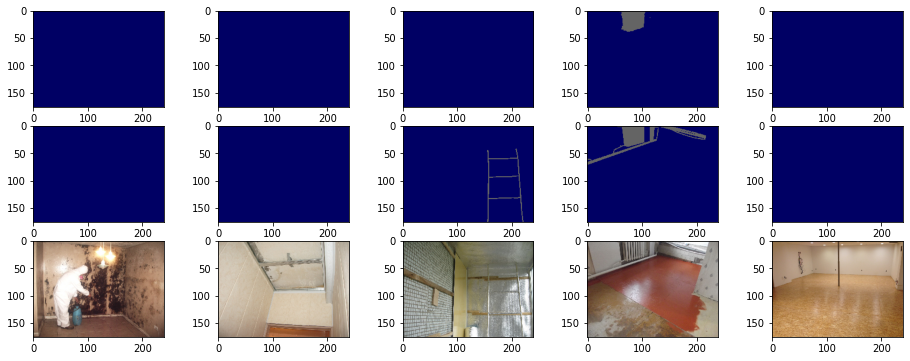

In [120]:
processImage(modelM3, 5, num_classes)

#### больше не запускать

In [107]:
# Функция преобразования пикселя сегментированного изображения в индекс (2 класса)
def color2index(color):
  index=-1
  if (249>=color[0]>=151) and(49>=color[1]>=0)    and(49>=color[2]>=0) : index=0 # батарея
  else: index = 1
  return index  

In [108]:
train_segments = [] # Создаем пустой список для хранений оригинльных изображений обучающей выборки
val_segments = [] # Создаем пустой список для хранений оригинльных изображений проверочной выборки

cur_time = time.time() # Засекаем текущее время
for filename in sorted(os.listdir(directory + train_directory+'/Размеченные')): # Проходим по всем файлам в каталоге по указанному пути     
    train_segments.append(image.load_img(os.path.join(directory + train_directory+'/Размеченные',filename),
                                       target_size=(img_width, img_height))) # Читаем очередную картинку и добавляем ее в список изображения с указанным target_size                                                      
print ('Обучающая выборка загружена. Время загрузки: ', round(time.time() - cur_time, 2), 'c', sep='') # Отображаем время загрузки картинок обучающей выборки
print ('Количество изображений: ', len(train_segments)) # Отображаем количество элементов в обучающем наборе сегментированных изображений

cur_time = time.time() # Засекаем текущее время
# Проходим по всем файлам в каталоге по указанному пути 
for filename in sorted(os.listdir(directory + val_directory+'/Размеченные')):
    # Читаем очередную картинку и добавляем ее в список изображения с указанным target_size                                                      
    val_segments.append(image.load_img(os.path.join(directory + val_directory+'/Размеченные',filename), 
                                     target_size=(img_width, img_height)))  # Читаем очередную картинку и добавляем ее в список изображения с указанным target_size   
print ('Проверочная выборка загружена. Время загрузки: ', round(time.time() - cur_time, 2), 'c', sep='') # Отображаем время загрузки картинок проверочной выборки
print ('Количество изображений: ', len(val_segments)) # Отображаем количество элементов в проверочном наборе сегментированных изображений

Обучающая выборка загружена. Время загрузки: 4.97c
Количество изображений:  900
Проверочная выборка загружена. Время загрузки: 0.27c
Количество изображений:  50


In [109]:
cur_time = time.time() # Засекаем текущее время
yTrain = yt_prep(train_segments, num_classes)  # Создаем yTrain
print('Время обработки: ', round(time.time() - cur_time, 2),'c') # Выводим время работы
np.save('yTrain_battery', yTrain)
yTrain.shape

100
200
300
400
500
600
700
800
900
Время обработки:  515.06 c


(900, 176, 240, 2)

In [110]:
cur_time = time.time() # Засекаем текущее время
yVal = yt_prep(val_segments, num_classes) # Создаем yVal
print('Время обработки: ', round(time.time() - cur_time, 2),'c') # Выводим время работы
np.save('yVal_battery', yVal)
yVal.shape

Время обработки:  29.33 c


(50, 176, 240, 2)

### Источники света

In [21]:
yTrain = np.load('yTrain_lights.npy')
yVal = np.load('yVal_lights.npy')
yTrain.shape, yVal.shape

((900, 176, 240, 2), (50, 176, 240, 2))

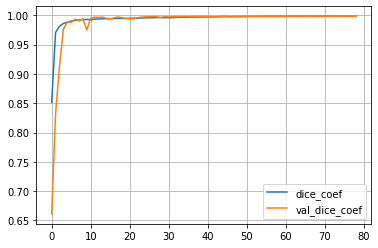

In [126]:
modelM3 = unetWithMask(num_classes, (img_width, img_height, 3))

#Коллбэки
early_stopping = EarlyStopping(monitor = 'val_dice_coef', patience = 12, verbose = 0, restore_best_weights = True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_dice_coef', factor=0.5, patience=5, min_lr=1e-06, verbose = 1, mode='max')
Checkpoint = ModelCheckpoint('modelM3_lights.h5', monitor='val_dice_coef', verbose=1, save_best_only=True, save_weights_only=True, mode='max')

# Обучаем модель simpleUnet
history = modelM3.fit(xTrain, yTrain, validation_data = (xVal, yVal),
                      epochs=100, batch_size=16, verbose=0,
                      callbacks = [early_stopping, reduce_lr, Checkpoint]) # Обучаем модель на выборке по 2м классам

#Выводим график точности распознавания на обучающей и проверочной выборках
clear_output()
plt.plot(history.history['dice_coef'], label='dice_coef')
plt.plot(history.history['val_dice_coef'], label='val_dice_coef')
plt.legend()
plt.grid()
plt.show()

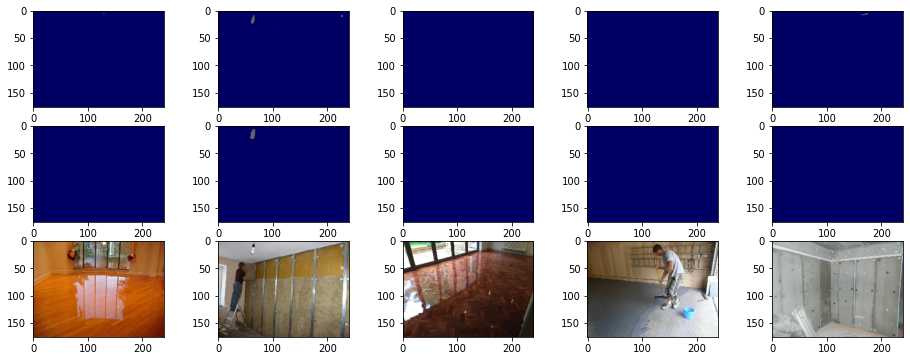

In [40]:
modelM3 = unetWithMask(num_classes, (img_width, img_height, 3))
modelM3.load_weights('/content/drive/My Drive/Занятие_12_Сегментация/data_стройка/modelM3_lights.h5')
processImage(modelM3, 5, num_classes)

#### больше не запускать

In [121]:
# Функция преобразования пикселя сегментированного изображения в индекс (2 класса)
def color2index(color):
  index=-1
  if (249>=color[0]>=151) and(249>=color[1]>=151) and(49>=color[2]>=0) : index=0 # источники света
  else: index = 1
  return index  

In [122]:
train_segments = [] # Создаем пустой список для хранений оригинльных изображений обучающей выборки
val_segments = [] # Создаем пустой список для хранений оригинльных изображений проверочной выборки

cur_time = time.time() # Засекаем текущее время
for filename in sorted(os.listdir(directory + train_directory+'/Размеченные')): # Проходим по всем файлам в каталоге по указанному пути     
    train_segments.append(image.load_img(os.path.join(directory + train_directory+'/Размеченные',filename),
                                       target_size=(img_width, img_height))) # Читаем очередную картинку и добавляем ее в список изображения с указанным target_size                                                      
print ('Обучающая выборка загружена. Время загрузки: ', round(time.time() - cur_time, 2), 'c', sep='') # Отображаем время загрузки картинок обучающей выборки
print ('Количество изображений: ', len(train_segments)) # Отображаем количество элементов в обучающем наборе сегментированных изображений

cur_time = time.time() # Засекаем текущее время
# Проходим по всем файлам в каталоге по указанному пути 
for filename in sorted(os.listdir(directory + val_directory+'/Размеченные')):
    # Читаем очередную картинку и добавляем ее в список изображения с указанным target_size                                                      
    val_segments.append(image.load_img(os.path.join(directory + val_directory+'/Размеченные',filename), 
                                     target_size=(img_width, img_height)))  # Читаем очередную картинку и добавляем ее в список изображения с указанным target_size   
print ('Проверочная выборка загружена. Время загрузки: ', round(time.time() - cur_time, 2), 'c', sep='') # Отображаем время загрузки картинок проверочной выборки
print ('Количество изображений: ', len(val_segments)) # Отображаем количество элементов в проверочном наборе сегментированных изображений

Обучающая выборка загружена. Время загрузки: 4.72c
Количество изображений:  900
Проверочная выборка загружена. Время загрузки: 0.26c
Количество изображений:  50


In [123]:
cur_time = time.time() # Засекаем текущее время
yTrain = yt_prep(train_segments, num_classes)  # Создаем yTrain
print('Время обработки: ', round(time.time() - cur_time, 2),'c') # Выводим время работы
np.save('yTrain_lights', yTrain)
yTrain.shape

100
200
300
400
500
600
700
800
900
Время обработки:  517.73 c


(900, 176, 240, 2)

In [124]:
cur_time = time.time() # Засекаем текущее время
yVal = yt_prep(val_segments, num_classes) # Создаем yVal
print('Время обработки: ', round(time.time() - cur_time, 2),'c') # Выводим время работы
np.save('yVal_lights', yVal)
yVal.shape

Время обработки:  29.61 c


(50, 176, 240, 2)

### Внешний мир

In [61]:
yTrain = np.load('yTrain_outside.npy')
yVal = np.load('yVal_outside.npy')
yTrain.shape, yVal.shape

((900, 176, 240, 7), (50, 176, 240, 7))

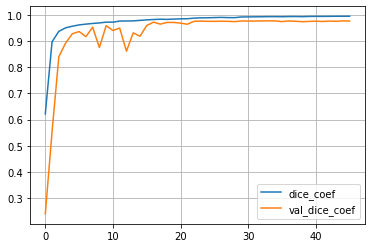

In [62]:
modelM3 = unetWithMask(num_classes, (img_width, img_height, 3))

#Коллбэки
early_stopping = EarlyStopping(monitor = 'val_dice_coef', patience = 12, verbose = 0, restore_best_weights = True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_dice_coef', factor=0.5, patience=5, min_lr=1e-06, verbose = 1, mode='max')
Checkpoint = ModelCheckpoint('modelM3_outside.h5', monitor='val_dice_coef', verbose=1, save_best_only=True, save_weights_only=True, mode='max')

# Обучаем модель simpleUnet
history = modelM3.fit(xTrain, yTrain, validation_data = (xVal, yVal),
                      epochs=100, batch_size=16, verbose=0,
                      callbacks = [early_stopping, reduce_lr, Checkpoint]) # Обучаем модель на выборке по 2м классам

#Выводим график точности распознавания на обучающей и проверочной выборках
clear_output()
plt.plot(history.history['dice_coef'], label='dice_coef')
plt.plot(history.history['val_dice_coef'], label='val_dice_coef')
plt.legend()
plt.grid()
plt.show()

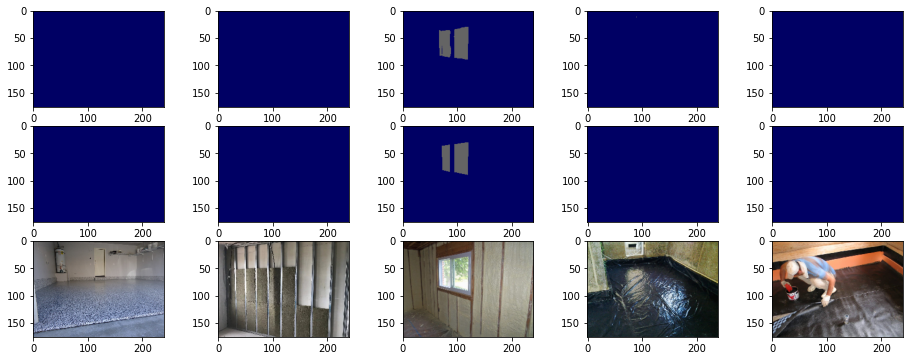

In [63]:
processImage(modelM3, 5, num_classes)

#### больше не запускать

In [41]:
# Функция преобразования пикселя сегментированного изображения в индекс (2 класса)
def color2index(color):
  index=-1
  if (249>=color[0]>=151) and(249>=color[1]>=151) and(249>=color[2]>=151) : index=0 # внешний мир
  else: index = 1
  return index  

In [56]:
train_segments = [] # Создаем пустой список для хранений оригинльных изображений обучающей выборки
val_segments = [] # Создаем пустой список для хранений оригинльных изображений проверочной выборки

cur_time = time.time() # Засекаем текущее время
for filename in sorted(os.listdir(directory + train_directory+'/Размеченные')): # Проходим по всем файлам в каталоге по указанному пути     
    train_segments.append(image.load_img(os.path.join(directory + train_directory+'/Размеченные',filename),
                                       target_size=(img_width, img_height))) # Читаем очередную картинку и добавляем ее в список изображения с указанным target_size                                                      
print ('Обучающая выборка загружена. Время загрузки: ', round(time.time() - cur_time, 2), 'c', sep='') # Отображаем время загрузки картинок обучающей выборки
print ('Количество изображений: ', len(train_segments)) # Отображаем количество элементов в обучающем наборе сегментированных изображений

cur_time = time.time() # Засекаем текущее время
# Проходим по всем файлам в каталоге по указанному пути 
for filename in sorted(os.listdir(directory + val_directory+'/Размеченные')):
    # Читаем очередную картинку и добавляем ее в список изображения с указанным target_size                                                      
    val_segments.append(image.load_img(os.path.join(directory + val_directory+'/Размеченные',filename), 
                                     target_size=(img_width, img_height)))  # Читаем очередную картинку и добавляем ее в список изображения с указанным target_size   
print ('Проверочная выборка загружена. Время загрузки: ', round(time.time() - cur_time, 2), 'c', sep='') # Отображаем время загрузки картинок проверочной выборки
print ('Количество изображений: ', len(val_segments)) # Отображаем количество элементов в проверочном наборе сегментированных изображений

Обучающая выборка загружена. Время загрузки: 4.69c
Количество изображений:  900
Проверочная выборка загружена. Время загрузки: 0.26c
Количество изображений:  50


In [59]:
cur_time = time.time() # Засекаем текущее время
yTrain = yt_prep(train_segments, num_classes)  # Создаем yTrain
print('Время обработки: ', round(time.time() - cur_time, 2),'c') # Выводим время работы
np.save('yTrain_outside', yTrain)
yTrain.shape

100
200
300
400
500
600
700
800
900
Время обработки:  532.71 c


(900, 176, 240, 7)

In [60]:
cur_time = time.time() # Засекаем текущее время
yVal = yt_prep(val_segments, num_classes) # Создаем yVal
print('Время обработки: ', round(time.time() - cur_time, 2),'c') # Выводим время работы
np.save('yVal_outside', yVal)
yVal.shape

Время обработки:  30.48 c


(50, 176, 240, 7)

#  Сделайте свою собственную архитектуру и запустите, оцените точность на проверочной выборке
----
сделал U-net, но усилил свертку Conv2D с (3,3) до (5,5)

In [8]:
'''
  Функция создания сети
    Входные параметры:
    - num_classes - количество классов
    - input_shape - размерность карты сегментации
'''
def unetWithMask_Unet(num_classes, input_shape= (352, 480, 3)):
    img_input = Input(input_shape)                                      # Создаем входной слой с размерностью input_shape

    # Block 1
    x = Conv2D(64, (5, 5), padding='same', name='block1_conv1')(img_input) # Добавляем Conv2D-слой с 64-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    x = Conv2D(64, (5, 5), padding='same', name='block1_conv2')(x)      # Добавляем Conv2D-слой с 64-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    block_1_out = Activation('relu')(x)                                 # Добавляем слой Activation и запоминаем в переменной block_1_out
    
    block_1_out_mask = Conv2D(64, (1, 1), padding='same')(block_1_out)  # Добавляем Conv2D-маску к текущему слою и запоминаем в переменную block_1_out_mask

    x = MaxPooling2D()(block_1_out) # Добавляем слой MaxPooling2D

    # Block 2
    x = Conv2D(128, (5, 5), padding='same', name='block2_conv1')(x)     # Добавляем Conv2D-слой с 128-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x) # Добавляем слой Activation

    x = Conv2D(128, (5, 5), padding='same', name='block2_conv2')(x)     # Добавляем Conv2D-слой с 128-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    block_2_out = Activation('relu')(x)                                 # Добавляем слой Activation и запоминаем в переменной block_2_out

    block_2_out_mask = Conv2D(128, (1, 1), padding='same')(block_2_out) # Добавляем Conv2D-маску к текущему слою и запоминаем в переменную block_2_out_mask
    
    x = MaxPooling2D()(block_2_out)                                     # Добавляем слой MaxPooling2D

    # Block 3
    x = Conv2D(256, (5, 5), padding='same', name='block3_conv1')(x)     # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    x = Conv2D(256, (5, 5), padding='same', name='block3_conv2')(x)     # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    x = Conv2D(256, (5, 5), padding='same', name='block3_conv3')(x)     # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    block_3_out = Activation('relu')(x)                                 # Добавляем слой Activation и запоминаем в переменной block_3_out

    block_3_out_mask = Conv2D(256, (1, 1), padding='same')(block_3_out) # Добавляем Conv2D-маску к текущему слою и запоминаем в переменную block_3_out_mask
        
    x = MaxPooling2D()(block_3_out)                                     # Добавляем слой MaxPooling2D

     # Block 4
    x = Conv2D(512, (5, 5), padding='same', name='block4_conv1')(x)     # Добавляем Conv2D-слой с 512-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    x = Conv2D(512, (5, 5), padding='same', name='block4_conv2')(x)     # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    x = Conv2D(512, (5, 5), padding='same', name='block4_conv3')(x)     # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    block_4_out = Activation('relu')(x)                                 # Добавляем слой Activation и запоминаем в переменной block_4_out

    block_4_out_mask = Conv2D(512, (1, 1), padding='same')(block_4_out) # Добавляем Conv2D-маску к текущему слою и запоминаем в переменную block_4_out_mask
            
    x = MaxPooling2D()(block_4_out)                                     # Добавляем слой MaxPooling2D

    # Block 5
    x = Conv2D(512, (5, 5), padding='same', name='block5_conv1')(x)     # Добавляем Conv2D-слой с 512-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    x = Conv2D(512, (5, 5), padding='same', name='block5_conv2')(x)     # Добавляем Conv2D-слой с 512-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    x = Conv2D(512, (5, 5), padding='same', name='block5_conv3')(x)     # Добавляем Conv2D-слой с 512-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation
    
    for_pretrained_weight = MaxPooling2D()(x)                           # Добавляем слой MaxPooling2D
 
    # UP 1
    x = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(x) # Добавляем слой Conv2DTranspose с 512 нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    x = concatenate([x, block_4_out, block_4_out_mask])                 # Объединем текущий слой со слоем block_4_out и слоем-маской block_4_out_mask
    x = Conv2D(512, (5, 5), padding='same')(x)                          # Добавляем слой Conv2D с 512 нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    x = Conv2D(512, (5, 5), padding='same')(x)                          # Добавляем слой Conv2D с 512 нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    # UP 2
    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x) # Добавляем слой Conv2DTranspose с 256 нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    x = concatenate([x, block_3_out, block_3_out_mask])                 # Объединем текущий слой со слоем block_3_out и слоем-маской block_3_out_mask
    x = Conv2D(256, (5, 5), padding='same')(x)                          # Добавляем слой Conv2D с 256 нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    x = Conv2D(256, (5, 5), padding='same')(x)                          # Добавляем слой Conv2D с 256 нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    # UP 3
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x) # Добавляем слой Conv2DTranspose с 128 нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    x = concatenate([x, block_2_out, block_2_out_mask])                 # Объединем текущий слой со слоем block_2_out и слоем-маской block_2_out_mask
    x = Conv2D(128, (5, 5), padding='same')(x)                          # Добавляем слой Conv2D с 128 нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    x = Conv2D(128, (5, 5), padding='same')(x)                          # Добавляем слой Conv2D с 128 нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    # UP 4
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x) # Добавляем слой Conv2DTranspose с 64 нейронами
    x = BatchNormalization()(x)                                        # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                          # Добавляем слой Activation

    x = concatenate([x, block_1_out, block_1_out_mask])                # Объединем текущий слой со слоем block_1_out и слоем-маской block_1_out_mask
    x = Conv2D(64, (5, 5), padding='same')(x)                          # Добавляем слой Conv2D с 128 нейронами
    x = BatchNormalization()(x)                                        # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                          # Добавляем слой Activation

    x = Conv2D(64, (5, 5), padding='same')(x)                          # Добавляем слой Conv2D с 128 нейронами
    x = BatchNormalization()(x)                                        # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                          # Добавляем слой Activation

    x = Conv2D(num_classes, (5, 5), activation='softmax', padding='same')(x) # Добавляем Conv2D-Слой с softmax-активацией на num_classes-нейронов

    model = Model(img_input, x)                                        # Создаем модель с входом 'img_input' и выходом 'x'

    # Компилируем модель 
    model.compile(optimizer=Adam(0.0002, 0.5), loss='categorical_crossentropy', metrics=[dice_coef])
    
    return model  

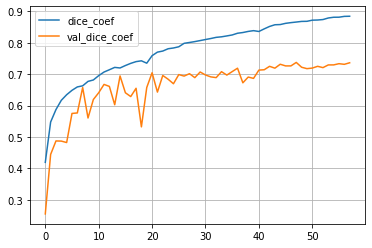

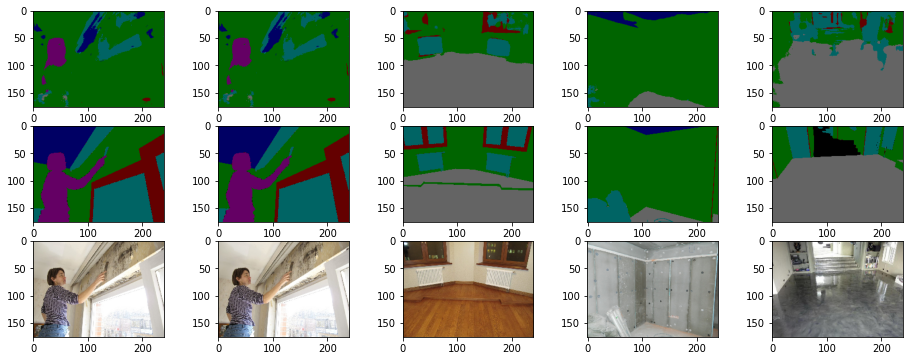

In [9]:
#Коллбэки
early_stopping = EarlyStopping(monitor = 'val_dice_coef', patience = 10, verbose = 0, restore_best_weights = True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_dice_coef', factor=0.5, patience=5, min_lr=1e-06, verbose = 0, mode='max')
Checkpoint = ModelCheckpoint('model_Unet.h5', monitor='val_dice_coef', verbose=1, save_best_only=True, save_weights_only=True, mode='max')


for batch_size in [15]:
  print ('\nbatch_size = ', batch_size)
  model_Unet = unetWithMask_Unet(num_classes, (img_width, img_height, 3))
  model_Unet.compile(optimizer=Adam(0.0002, 0.5), loss='categorical_crossentropy', metrics=[dice_coef])

  # Обучаем модель simpleUnet
  history = model_Unet.fit(xTrain, yTrain, validation_data = (xVal, yVal),
                            epochs=100, batch_size = batch_size, verbose=0,
                            callbacks = [early_stopping, reduce_lr, Checkpoint])

  #Выводим график точности распознавания на обучающей и проверочной выборках
  clear_output()
  plt.plot(history.history['dice_coef'], label='dice_coef')
  plt.plot(history.history['val_dice_coef'], label='val_dice_coef')
  plt.legend()
  plt.grid()
  plt.show()

  #modelM3 = unetWithMask(num_classes, (img_width, img_height, 3))
  model_Unet.load_weights('/content/drive/My Drive/Занятие_12_Сегментация/data_стройка/model_Unet.h5')
  processImage(model_Unet, 5, num_classes)

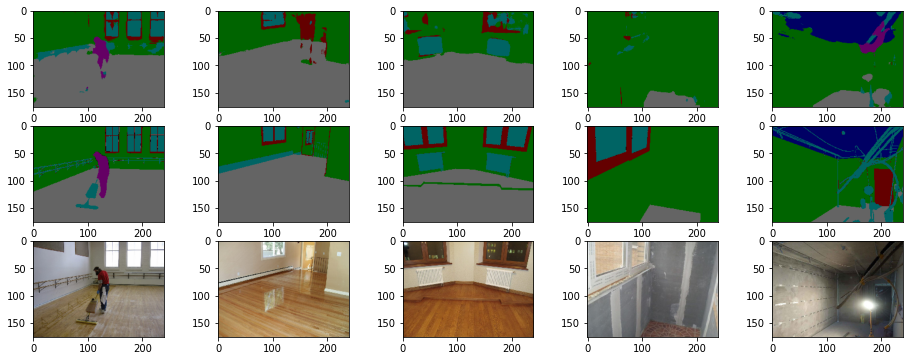

In [11]:
  #modelM3 = unetWithMask(num_classes, (img_width, img_height, 3))
  model_Unet.load_weights('/content/drive/My Drive/Занятие_12_Сегментация/data_стройка/model_Unet.h5')
  processImage(model_Unet, 5, num_classes)

# Проверьте различные batch_size

In [67]:
# Глобальные параметры
num_classes = 7 # Задаем количество классов на изображении

os.chdir('/content/drive/My Drive/Занятие_12_Сегментация/data_стройка')
xTrain, yTrain = np.load('xTrain.npy'), np.load('yTrain.npy')
xVal, yVal= np.load('xVal.npy'), np.load('yVal.npy')
print('xTrain\t', xTrain.shape, '\nyTrain\t', yTrain.shape,
      '\nxVal\t', xVal.shape, '\nyVal\t', yVal.shape)

xTrain	 (900, 176, 240, 3) 
yTrain	 (900, 176, 240, 7) 
xVal	 (50, 176, 240, 3) 
yVal	 (50, 176, 240, 7)



batch_size =  30


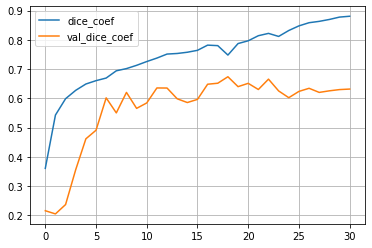

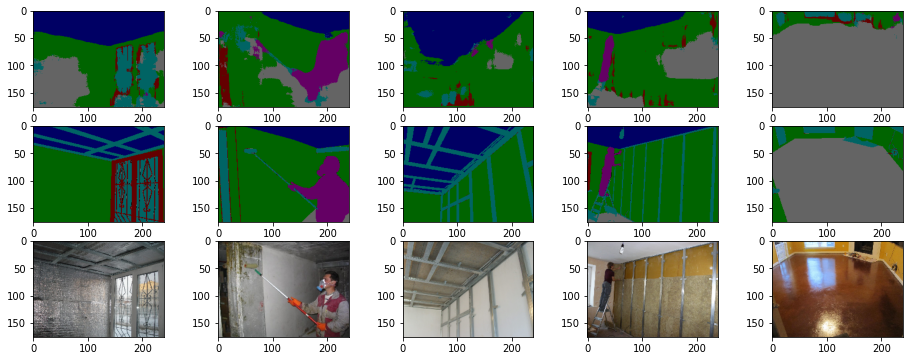


batch_size =  15


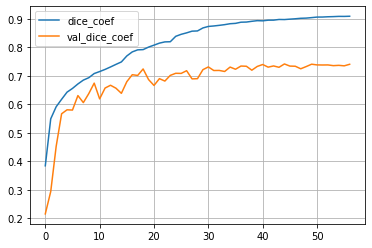

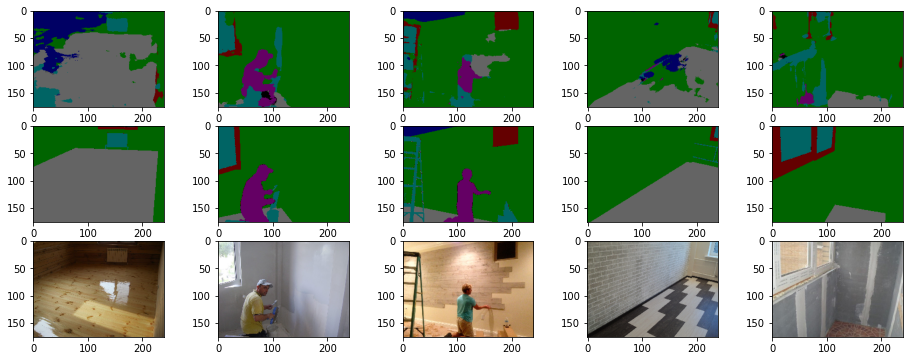


batch_size =  5


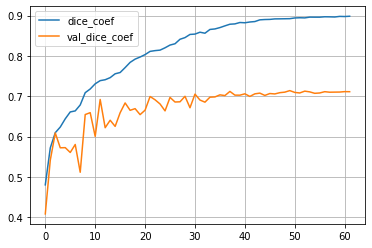

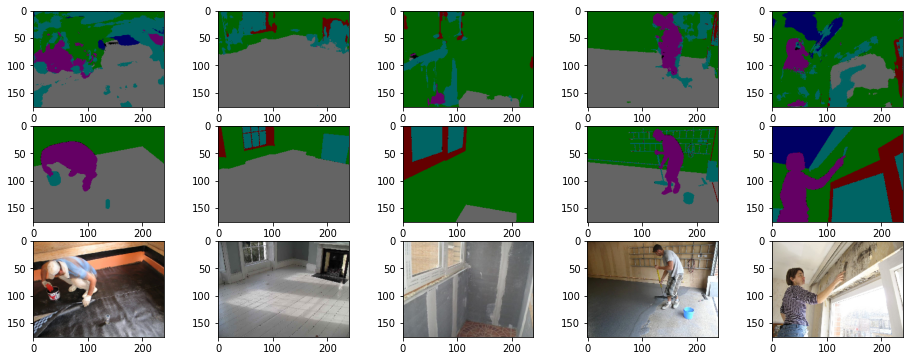

In [72]:
#Коллбэки
early_stopping = EarlyStopping(monitor = 'val_dice_coef', patience = 12, verbose = 0, restore_best_weights = True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_dice_coef', factor=0.5, patience=5, min_lr=1e-06, verbose = 0, mode='max')
Checkpoint = ModelCheckpoint('modelM3.h5', monitor='val_dice_coef', verbose=0, save_best_only=True, save_weights_only=True, mode='max')


for batch_size in [30, 15, 5]:
  print ('\nbatch_size = ', batch_size)
  modelM3 = unetWithMask(num_classes, (img_width, img_height, 3))
  modelM3.compile(optimizer=Adam(0.0002, 0.5), loss='categorical_crossentropy', metrics=[dice_coef])

  # Обучаем модель simpleUnet
  history = modelM3.fit(xTrain, yTrain, validation_data = (xVal, yVal),
                      epochs=100, batch_size = batch_size, verbose=0,
                      callbacks = [early_stopping, reduce_lr, Checkpoint]) # Обучаем модель на выборке по 7 классам

  #Выводим график точности распознавания на обучающей и проверочной выборках
  #clear_output()
  plt.plot(history.history['dice_coef'], label='dice_coef')
  plt.plot(history.history['val_dice_coef'], label='val_dice_coef')
  plt.legend()
  plt.grid()
  plt.show()

  #modelM3 = unetWithMask(num_classes, (img_width, img_height, 3))
  modelM3.load_weights('/content/drive/My Drive/Занятие_12_Сегментация/data_стройка/modelM3.h5')
  processImage(modelM3, 5, num_classes)

# Проверьте различные активационные функции

In [36]:
'''
  Функция создания сети
    Входные параметры:
    - num_classes - количество классов
    - input_shape - размерность карты сегментации
'''
def unetWithMask_Unet(Activ, num_classes, input_shape= (352, 480, 3)):
    img_input = Input(input_shape)                                      # Создаем входной слой с размерностью input_shape

    # Block 1
    x = Conv2D(64, (6,6), padding='same', name='block1_conv1')(img_input) # Добавляем Conv2D-слой с 64-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation(Activ)(x)                                           # Добавляем слой Activation

    x = Conv2D(64, (6,6), padding='same', name='block1_conv2')(x)      # Добавляем Conv2D-слой с 64-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    block_1_out = Activation(Activ)(x)                                 # Добавляем слой Activation и запоминаем в переменной block_1_out
    
    block_1_out_mask = Conv2D(64, (1, 1), padding='same')(block_1_out)  # Добавляем Conv2D-маску к текущему слою и запоминаем в переменную block_1_out_mask

    x = MaxPooling2D()(block_1_out) # Добавляем слой MaxPooling2D

    # Block 2
    x = Conv2D(128, (5, 5), padding='same', name='block2_conv1')(x)     # Добавляем Conv2D-слой с 128-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation(Activ)(x) # Добавляем слой Activation

    x = Conv2D(128, (5, 5), padding='same', name='block2_conv2')(x)     # Добавляем Conv2D-слой с 128-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    block_2_out = Activation(Activ)(x)                                 # Добавляем слой Activation и запоминаем в переменной block_2_out

    block_2_out_mask = Conv2D(128, (1, 1), padding='same')(block_2_out) # Добавляем Conv2D-маску к текущему слою и запоминаем в переменную block_2_out_mask
    
    x = MaxPooling2D()(block_2_out)                                     # Добавляем слой MaxPooling2D

    # Block 3
    x = Conv2D(256, (5, 5), padding='same', name='block3_conv1')(x)     # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation(Activ)(x)                                           # Добавляем слой Activation

    x = Conv2D(256, (5, 5), padding='same', name='block3_conv2')(x)     # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation(Activ)(x)                                           # Добавляем слой Activation

    x = Conv2D(256, (5, 5), padding='same', name='block3_conv3')(x)     # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    block_3_out = Activation(Activ)(x)                                 # Добавляем слой Activation и запоминаем в переменной block_3_out

    block_3_out_mask = Conv2D(256, (1, 1), padding='same')(block_3_out) # Добавляем Conv2D-маску к текущему слою и запоминаем в переменную block_3_out_mask
        
    x = MaxPooling2D()(block_3_out)                                     # Добавляем слой MaxPooling2D

     # Block 4
    x = Conv2D(512, (5, 5), padding='same', name='block4_conv1')(x)     # Добавляем Conv2D-слой с 512-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation(Activ)(x)                                           # Добавляем слой Activation

    x = Conv2D(512, (5, 5), padding='same', name='block4_conv2')(x)     # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation(Activ)(x)                                           # Добавляем слой Activation

    x = Conv2D(512, (5, 5), padding='same', name='block4_conv3')(x)     # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    block_4_out = Activation(Activ)(x)                                 # Добавляем слой Activation и запоминаем в переменной block_4_out

    block_4_out_mask = Conv2D(512, (1, 1), padding='same')(block_4_out) # Добавляем Conv2D-маску к текущему слою и запоминаем в переменную block_4_out_mask
            
    x = MaxPooling2D()(block_4_out)                                     # Добавляем слой MaxPooling2D

    # Block 5
    x = Conv2D(512, (5, 5), padding='same', name='block5_conv1')(x)     # Добавляем Conv2D-слой с 512-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation(Activ)(x)                                           # Добавляем слой Activation

    x = Conv2D(512, (5, 5), padding='same', name='block5_conv2')(x)     # Добавляем Conv2D-слой с 512-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation(Activ)(x)                                           # Добавляем слой Activation

    x = Conv2D(512, (5, 5), padding='same', name='block5_conv3')(x)     # Добавляем Conv2D-слой с 512-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation(Activ)(x)                                           # Добавляем слой Activation
    
    for_pretrained_weight = MaxPooling2D()(x)                           # Добавляем слой MaxPooling2D
 
    # UP 1
    x = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(x) # Добавляем слой Conv2DTranspose с 512 нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation(Activ)(x)                                           # Добавляем слой Activation

    x = concatenate([x, block_4_out, block_4_out_mask])                 # Объединем текущий слой со слоем block_4_out и слоем-маской block_4_out_mask
    x = Conv2D(512, (5, 5), padding='same')(x)                          # Добавляем слой Conv2D с 512 нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation(Activ)(x)                                           # Добавляем слой Activation

    x = Conv2D(512, (5, 5), padding='same')(x)                          # Добавляем слой Conv2D с 512 нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation(Activ)(x)                                           # Добавляем слой Activation

    # UP 2
    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x) # Добавляем слой Conv2DTranspose с 256 нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation(Activ)(x)                                           # Добавляем слой Activation

    x = concatenate([x, block_3_out, block_3_out_mask])                 # Объединем текущий слой со слоем block_3_out и слоем-маской block_3_out_mask
    x = Conv2D(256, (5, 5), padding='same')(x)                          # Добавляем слой Conv2D с 256 нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation(Activ)(x)                                           # Добавляем слой Activation

    x = Conv2D(256, (5, 5), padding='same')(x)                          # Добавляем слой Conv2D с 256 нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation(Activ)(x)                                           # Добавляем слой Activation

    # UP 3
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x) # Добавляем слой Conv2DTranspose с 128 нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation(Activ)(x)                                           # Добавляем слой Activation

    x = concatenate([x, block_2_out, block_2_out_mask])                 # Объединем текущий слой со слоем block_2_out и слоем-маской block_2_out_mask
    x = Conv2D(128, (5, 5), padding='same')(x)                          # Добавляем слой Conv2D с 128 нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation(Activ)(x)                                           # Добавляем слой Activation

    x = Conv2D(128, (5, 5), padding='same')(x)                          # Добавляем слой Conv2D с 128 нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation(Activ)(x)                                           # Добавляем слой Activation

    # UP 4
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x) # Добавляем слой Conv2DTranspose с 64 нейронами
    x = BatchNormalization()(x)                                        # Добавляем слой BatchNormalization
    x = Activation(Activ)(x)                                          # Добавляем слой Activation

    x = concatenate([x, block_1_out, block_1_out_mask])                # Объединем текущий слой со слоем block_1_out и слоем-маской block_1_out_mask
    x = Conv2D(64, (6,6), padding='same')(x)                          # Добавляем слой Conv2D с 128 нейронами
    x = BatchNormalization()(x)                                        # Добавляем слой BatchNormalization
    x = Activation(Activ)(x)                                          # Добавляем слой Activation

    x = Conv2D(64, (6,6), padding='same')(x)                          # Добавляем слой Conv2D с 128 нейронами
    x = BatchNormalization()(x)                                        # Добавляем слой BatchNormalization
    x = Activation(Activ)(x)                                          # Добавляем слой Activation

    x = Conv2D(num_classes, (6,6), activation='softmax', padding='same')(x) # Добавляем Conv2D-Слой с softmax-активацией на num_classes-нейронов

    model = Model(img_input, x)                                        # Создаем модель с входом 'img_input' и выходом 'x'

    # Компилируем модель 
    model.compile(optimizer=Adam(0.0002, 0.5), loss='categorical_crossentropy', metrics=[dice_coef])
    
    return model  


Activation =  softplus


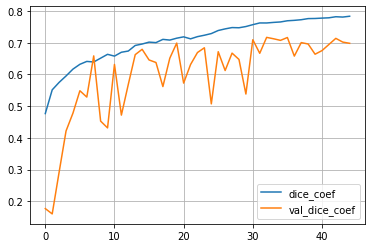

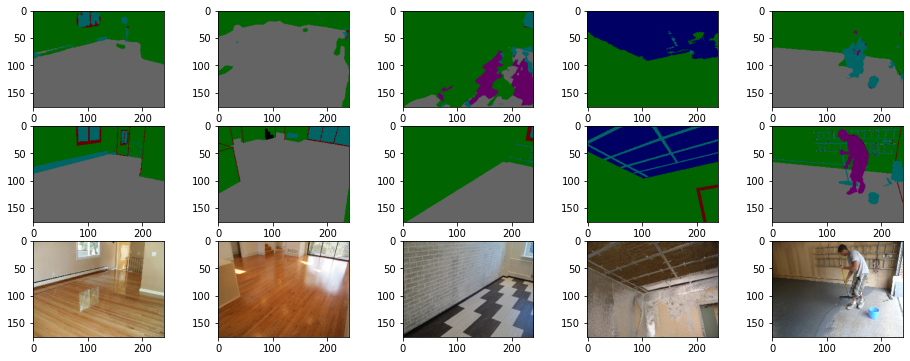


Activation =  elu


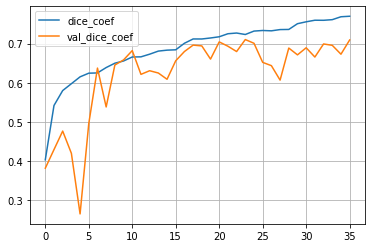

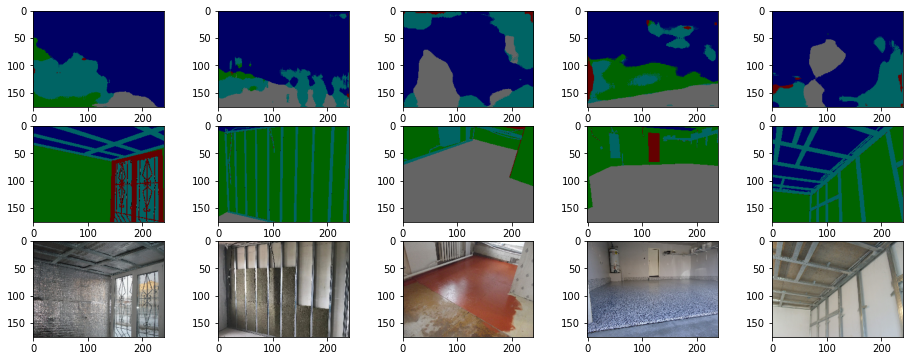


Activation =  tanh


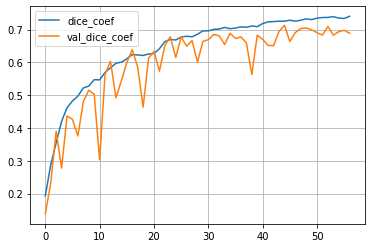

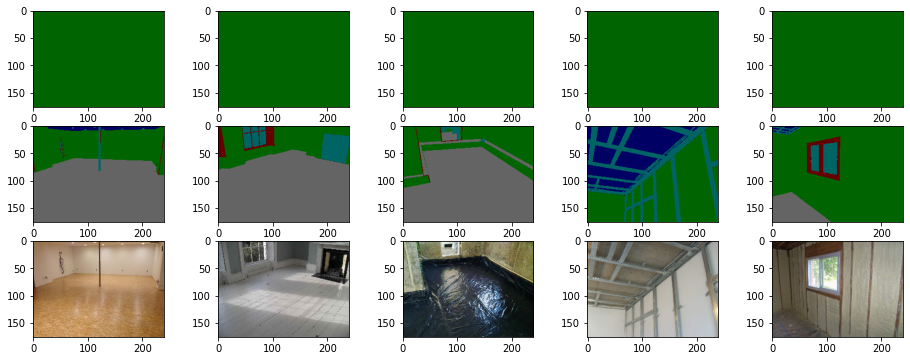


Activation =  relu


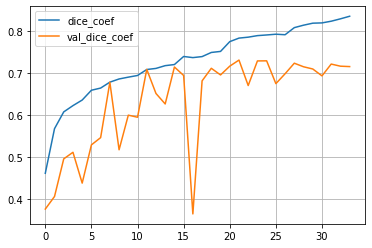

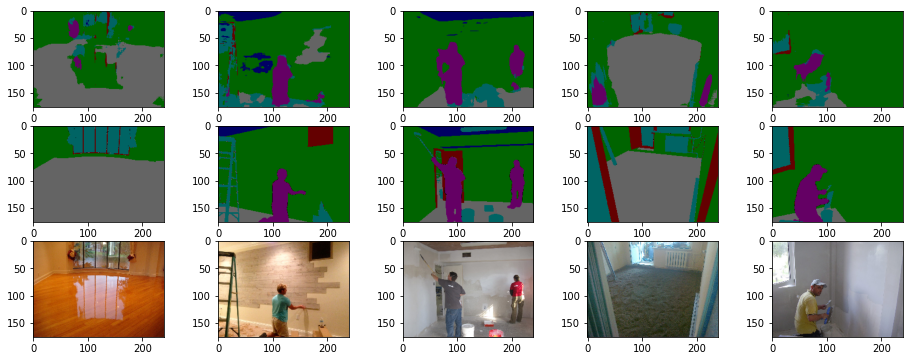

In [38]:
#Коллбэки
early_stopping = EarlyStopping(monitor = 'val_dice_coef', patience = 12, verbose = 0, restore_best_weights = True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_dice_coef', factor=0.5, patience=5, min_lr=1e-06, verbose = 0, mode='max')
Checkpoint = ModelCheckpoint('model_Unet.h5', monitor='val_dice_coef', verbose=0, save_best_only=True, save_weights_only=True, mode='max')

batch_size = 15
for Activ in ['softplus', 'elu', 'tanh', 'relu']:
  model_Unet = unetWithMask_Unet(Activ, num_classes, (img_width, img_height, 3))
  model_Unet.compile(optimizer=Adam(0.0002, 0.5), loss='categorical_crossentropy', metrics=[dice_coef])

  # Обучаем модель simpleUnet
  history = model_Unet.fit(xTrain, yTrain, validation_data = (xVal, yVal),
                            epochs=60, batch_size = batch_size, verbose=0,
                            callbacks = [early_stopping, reduce_lr, Checkpoint])

  #Выводим график точности распознавания на обучающей и проверочной выборках
  #clear_output()
  print ('\nActivation = ', Activ)
  plt.plot(history.history['dice_coef'], label='dice_coef')
  plt.plot(history.history['val_dice_coef'], label='val_dice_coef')
  plt.legend()
  plt.grid()
  plt.show()

  #modelM3 = unetWithMask(num_classes, (img_width, img_height, 3))
  model_Unet.load_weights('/content/drive/My Drive/Занятие_12_Сегментация/data_стройка/model_Unet.h5')
  processImage(model_Unet, 5, num_classes)

# Выводы:
-----
1. Лучше делать отдельные нейронки для каждого класса обьектов
2. Озадачили результаты эксперимента с разными активационными функциями. При достаточно высоких показателях ошибки, при проверке выявилась очевидная неспособность определить обьекты для активаторов 'softplus', 'elu', 'tanh'
3. При увеличении размера батча качество, как и ожидалось, падало